# Single-neuron-level analysis

### Analysis pipeline for concatenated recordings

*** To save notebook as pdf without code: ***
https://stackoverflow.com/questions/34818723/export-notebook-to-pdf-without-code?noredirect=1&lq=1

In [117]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.signal import medfilt 

from scipy.stats import skew, kurtosis, zscore

from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

In [2]:
from capipeline import *

/media/andrey/My Passport/OASIS-master/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


# Setup path and choose animals for the analysis

In [110]:
animals =['TS_C_MMF_8237']

database_path = '/media/andrey/My Passport/GIN/Anesthesia_CA1/meta_data/meta_recordings_transition_state.xlsx'

rec = get_recordings_for_animals(animals, database_path)

print("Regordings for analysis: " + str(rec) )

Regordings for analysis: [18, 19, 20, 21, 22, 23, 24, 25, 26]


### Plot raster plot for the first three recordings 

Total trace length: 85000
Recording length: 5694
Analysis periods: [0, 5000]
Analysis period total frames:  5000
Median baseline: 36.39
Total trace length: 85000
Recording length: 9000
Analysis periods: [0, 5000]
Analysis period total frames:  5000
Total trace length: 85000
Recording length: 7269
Analysis periods: [2100, 7100]
Analysis period total frames:  5000


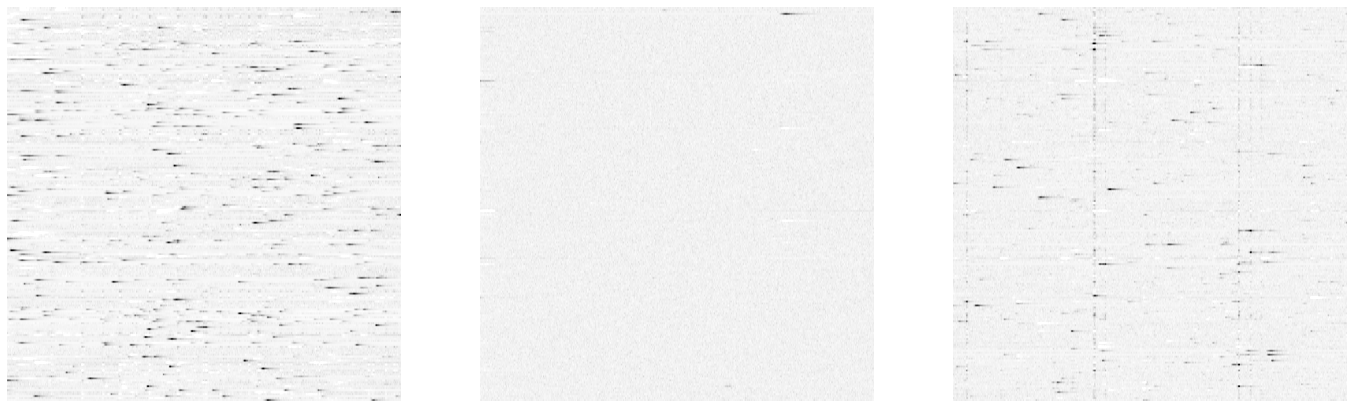

In [115]:
nrec_to_plot = 3
starting_recording = rec[0]

fig, axes = plt.subplots(1, nrec_to_plot, figsize=(8*nrec_to_plot, 8), sharex=True)

for j in range(0,nrec_to_plot):
    
    raster = get_raster(starting_recording+j, 200, database_path, concatenation=True)

    axes[j].imshow(raster,extent=(0,7000,0,7000),cmap='Greys',vmin=0.25,vmax=1.0)
    
    axes[j].axis('off')

plt.show()

# Reprocess data (may take some time) or load reprocessed data (see below)

Regordings for analysis: [18, 19, 20, 21, 22, 23, 24, 25, 26]
TS_C_MMF_8237 18 
Threshold for peak detection: 160
18 TS_C_MMF_8237 awake


KeyboardInterrupt: 

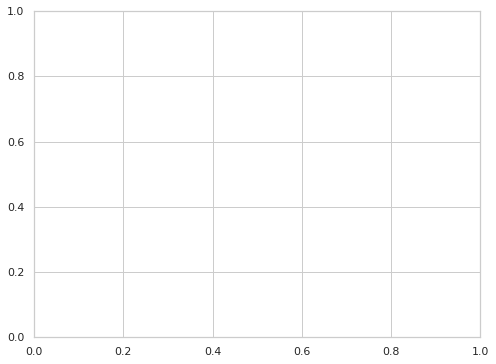

In [88]:
#### WHAT TO DO WITH EXCLUDED VALUES???

df_estimators = pd.DataFrame()

df_corrs =  pd.DataFrame()

for r in rec:
    
    animal = get_animal_from_recording(r, database_path)
    
    print(str(animal) + " " + str(r) + " ")

    if (animal=='TS_C_MMF_8237'): ### assign threshold
         threshold = 160
        
    print("Threshold for peak detection: " + str(threshold))
    df_e, df_c   = get_data_frame(r, database_path, threshold=threshold, baseline_correction=True,concatination=True)

    df_estimators = pd.concat([df_estimators,df_e])
    df_corrs = pd.concat([df_corrs,df_c])

    print("*****")

    
df_estimators['neuronID'] = df_estimators.index

### Store data frames

In [24]:
df_estimators.to_pickle("./df_estimators_TS_C_MMF_8237_n_peaks_baseline.pkl") 
df_corrs.to_pickle("./df_corrs_TS_C_MMF_8237_n_peaks_baseline.pkl") 

# Load reprocessed data

In [97]:
df_estimators = pd.read_pickle("./df_estimators_TS_C_MMF_8237_n_peaks_baseline.pkl")
df_corrs = pd.read_pickle("./df_corrs_TS_C_MMF_8237_n_peaks_baseline.pkl")

### Check availible conditions

In [98]:
np.unique(df_estimators_conditions.condition)

array(['awake', 'mmf', 'post120', 'post180', 'post240', 'post30',
       'post300', 'post360', 'post60'], dtype=object)

### Get statistics on the features and correlations 

**Main features (df_estimators):**

- n_peaks
- width.median
- height.median
- decay time
- skewness
- integral
- baseline
- number of active neurons

**Correlations (df_corrs):**

- Pearson correlation of neurons 
- absolute Pearson correlation of neurons

In [116]:
df_estimators.describe()

,recording,neuronID,n.accepted,length.frames,length.minutes,n.accepted_and_rejected,traces.median,npil.median,trace.std,npil.std,...,baseline.oasis,integral,Tm0p7Ncorr.mean,peak_detection_threshold,decay_isol,decay_no_isol,n_peaks,n_peaks_per_recording,height.median,width.median
count,10530.000000,10530.000000,10530.0,10530.000000,10530.000000,10530.0,10530.000000,10530.000000,10530.000000,10530.000000,...,10530.000000,10530.000000,10530.000000,10530.0,10530.000000,10530.000000,10530.000000,10530.000000,8573.000000,8573.000000
mean,22.000000,584.500000,1170.0,5111.111111,2.839506,2429.0,276.193268,256.982513,27.906294,27.906294,...,33.851483,70.530825,0.001777,160.0,2.358118,0.668918,40.585704,115.607597,255.688462,61.612957
std,2.582112,337.765823,0.0,314.284604,0.174603,0.0,178.007980,136.855087,27.797024,27.797024,...,59.080215,105.885473,0.004410,0.0,7.770262,0.491665,44.048309,126.088156,119.514399,179.706254
min,18.000000,0.000000,1170.0,5000.000000,2.777778,2429.0,0.000000,42.001099,3.671381,3.671381,...,0.000000,-568.994583,-0.024061,160.0,0.004825,0.005221,0.000000,0.000000,160.036316,1.847015
25%,20.000000,292.000000,1170.0,5000.000000,2.777778,2429.0,155.743740,155.073753,12.949378,12.949378,...,0.000039,7.469192,0.000040,160.0,0.106243,0.183865,0.720000,2.000000,183.627823,12.684397
50%,22.000000,584.500000,1170.0,5000.000000,2.777778,2429.0,232.062943,220.850372,19.934484,19.934484,...,7.998768,53.638537,0.001451,160.0,0.352873,0.635967,19.440000,55.000000,210.574097,20.093484
75%,24.000000,877.000000,1170.0,5000.000000,2.777778,2429.0,349.728149,328.991821,31.527514,31.527514,...,46.124276,113.528742,0.003599,160.0,0.555078,1.103994,82.800000,234.000000,282.922668,45.549530
max,26.000000,1169.000000,1170.0,6000.000000,3.333333,2429.0,1661.458862,949.584839,372.736633,372.736633,...,842.286785,917.365800,0.026182,160.0,33.316664,1.649311,131.760000,439.000000,1405.087036,4866.486644


In [100]:
df_corrs.describe()

,recording,Tm0p7Ncorr,Tm0p7Ncorr.abs
count,1.232010e+07,1.230957e+07,1.230957e+07
mean,2.200000e+01,9.229237e-04,3.036242e-02
std,2.581989e+00,5.583744e-02,4.686998e-02
min,1.800000e+01,-9.883481e-01,3.660796e-09
25%,2.000000e+01,-1.709684e-02,7.662017e-03
50%,2.200000e+01,-8.603377e-05,1.701841e-02
75%,2.400000e+01,1.693834e-02,3.396463e-02
max,2.600000e+01,9.913196e-01,9.913196e-01


### Get median value of the feature for a given animal

In [101]:
df_estimators[(df_estimators.animal=='TS_C_MMF_8237')].groupby('condition', as_index=False)['n_peaks'].median()

,condition,n_peaks
0,awake,18.72
1,mmf,0.00
2,post120,30.30
3,post180,35.46
4,post240,25.56
5,post30,4.32
6,post300,42.12
7,post360,42.84
8,post60,18.00


In [102]:
df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.999)].groupby('condition', as_index=False)['Tm0p7Ncorr.abs'].median()

,condition,Tm0p7Ncorr.abs
0,awake,0.026326
1,mmf,0.009634
2,post120,0.014517
3,post180,0.017756
4,post240,0.016682
5,post30,0.014929
6,post300,0.023240
7,post360,0.036034
8,post60,0.013139


### Violin plot for a given feature

<AxesSubplot:xlabel='condition', ylabel='n_peaks'>

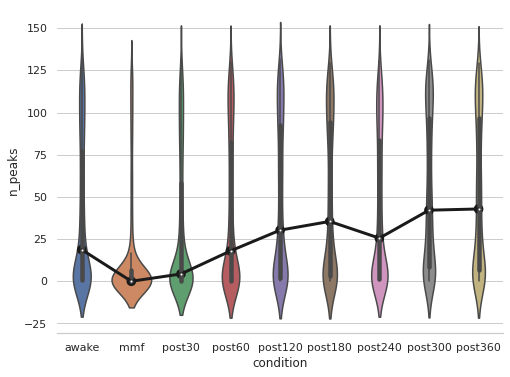

In [49]:
feature = 'n_peaks' # number of peaks per min
conditions = ["awake","mmf","post30","post60","post120","post180","post240","post300","post360"]

f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.despine(left=True)
#axes.set_ylim([0, 100.0])
sns.violinplot(x='condition', y=feature, data=df_estimators,ax=axes,order = conditions)
sns.pointplot(x='condition', y=feature, markers='o', scale=1.1, color='k',data=df_estimators.groupby('condition', as_index=False)['n_peaks'].median(), ax=axes,order=conditions)

### Violin plot for correlations

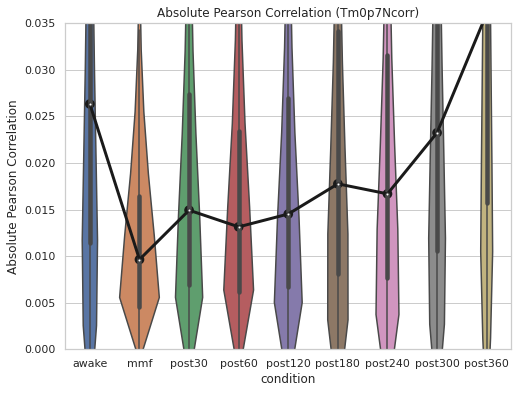

In [59]:
plt.rcParams['figure.figsize'] = [8, 6]

sns.violinplot(x='condition', y='Tm0p7Ncorr.abs',data=df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.9)],order=["awake","mmf","post30","post60","post120","post180","post240","post300","post360"])
sns.pointplot(x='condition', y='Tm0p7Ncorr.abs', markers='o', scale=1.1, color='k',data=df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.9)].groupby('condition', as_index=False)['Tm0p7Ncorr.abs'].median(),order=["awake","mmf","post30","post60","post120","post180","post240","post300","post360"])

plt.ylim([-0.00,0.035])
#plt.yscale('log')
#plt.savefig("correlations.png")
#plt.savefig("correlations.eps")
plt.title("Absolute Pearson Correlation (Tm0p7Ncorr)")
plt.ylabel("Absolute Pearson Correlation")
plt.show()

# Single-neuron level analysis

In [104]:
df_estimators['neuronID'] = df_estimators.index # make a column from neuronID (to be removed from here and added to the reprocessing)

Text(0.5, 1.0, 'Animal 8237; MMF')

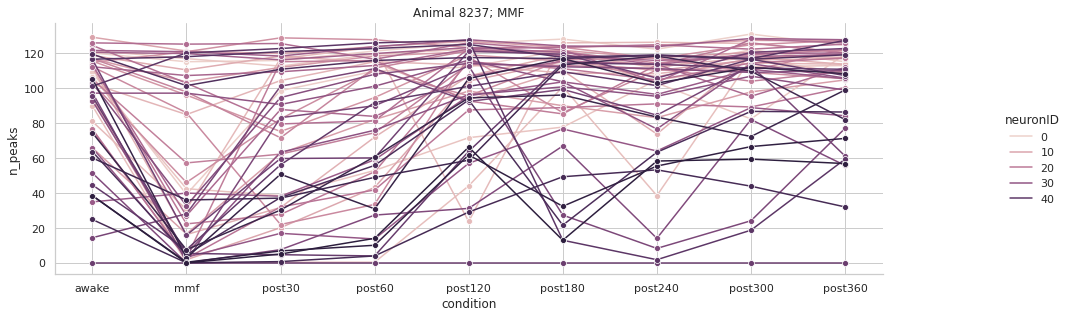

In [120]:
g=sns.relplot(x = 'condition',y = 'n_peaks', data = df_estimators[df_estimators.neuronID<50], marker='o',hue='neuronID',kind='line')
g.fig.set_size_inches(16,4)
plt.title("Animal 8237; MMF")

# Single-neuron level analysis (interactive)

### Number of transients in different conditions; color represents median hight of transients, while size their median decay time

In [108]:
import plotly.express as px

x_axis = "condition"
y_axis = "n_peaks"
line_group = "neuronID"
color = "neuronID"

fig = px.line(df_estimators[df_estimators.neuronID<50], x=x_axis, y=y_axis, line_group=line_group,color=color)
fig.show()

In [107]:
import plotly.express as px

x_axis = "condition"
y_axis = "n_peaks"
marker_color = "height.median"
marker_size = 'decay_no_isol'

fig = px.scatter(df_estimators[df_estimators.neuronID<50], x=x_axis, y=y_axis, color=marker_color,
                 size=marker_size)
fig.show()